Load required libraries.

In [0]:
import tensorflow as tf
import numpy as np
import os
import time
from datetime import datetime
import scipy
from scipy.io import wavfile
#print(scipy.__version__)
import matplotlib.pyplot as plot
from google.colab import drive
drive.mount('/content/drive')

Setup variables.

In [8]:
external_file = "https://gitlab.com/michael-lewis/wav-nn/-/raw/master/input/440hzsine-8bit22050hzmono.wav?inline=false"
#external_file = "https://gitlab.com/michael-lewis/wav-nn/-/raw/master/input/beethoven7th2nd-8bit22050hzmono.wav?inline=false"
#input_file = "input/440hzsine-8bit22050hzmono.wav"
input_file = "/tmp/inputfile.wav"
output_file = '/content/drive/My Drive/Colab Notebooks/generated-8bit22050hzmono.raw'

!wget --no-check-certificate $external_file -O /tmp/inputfile.wav

window_size = 300 # The maximum length we want for a single input
batch_size = 64 # Batch size
shuffle_buffer_size = 10000 # Buffer size to shuffle the dataset

#checkpoint_dir = './training_checkpoints' # Directory where the checkpoints will be saved
checkpoint_dir = '/content/drive/My Drive/Colab Notebooks/checkpoints/'

epochs = 10

output_length = 110 # Number of samples in the output file

--2020-05-29 11:19:26--  https://gitlab.com/michael-lewis/wav-nn/-/raw/master/input/440hzsine-8bit22050hzmono.wav?inline=false
Resolving gitlab.com (gitlab.com)... 172.65.251.78, 2606:4700:90:0:f22e:fbec:5bed:a9b9
Connecting to gitlab.com (gitlab.com)|172.65.251.78|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 44144 (43K) [audio/wave]
Saving to: ‘/tmp/inputfile.wav’

/tmp/inputfile.wav  100%[===================>]  43.11K  --.-KB/s    in 0.002s  

2020-05-29 11:19:26 (20.9 MB/s) - ‘/tmp/inputfile.wav’ saved [44144/44144]



Load the wav file into a numpy array.

In [9]:
def load_wavfile_as_array():
    samplerate, wavarray = wavfile.read(input_file)
    # If we use an RNN/LSTM in the first layer, we need to use one of
    # bfloat16, float16, float32, float64, int32, int64, complex64, complex128
    wavarraytype = wavarray.dtype
    if wavarraytype == "uint8":
        print("We can't use uint8 if we have an RNN/LSTM in the first layer. Converting to int32.")
        wavarray = wavarray.astype(np.int32) # convert to int32
    return samplerate, wavarray

samplerate, wavarray = load_wavfile_as_array()

We can't use uint8 if we have an RNN/LSTM in the first layer. Converting to int32.


Split data into training and validation, and create windowed dataset for each.

In [0]:
def get_split(wavarray):
    split = int(len(wavarray) * 0.8)
    return split

def create_windowed_dataset(input_array, window_size, batch_size, shuffle_buffer):
    # We don't need expand_dims if the first layer is not an RNN/LSTM, because 
    # in those cases we only need a 2 dimensional shape, i.e. batch size and number of time steps
    # However, if we use an RNN/LSTM in the first layer, the input shape has to be 3 dimensions, i.e.
    # batch size, number of time steps and series dimensionality (1 for univariate, appropriate no for multi)
    # An Embedding layer as the first layer would also address this
    input_array = tf.expand_dims(input_array, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(input_array)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda window: window.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda window: (window[:-1], window[-1])) # Window is all but the last, and the last
    ds = ds.batch(batch_size).prefetch(1)
    return ds

split = get_split(wavarray)
train_array = wavarray[:split]
validate_array = wavarray[split:]
train_dataset = create_windowed_dataset(train_array, window_size, batch_size, shuffle_buffer_size)
validation_dataset = create_windowed_dataset(validate_array, window_size, batch_size, shuffle_buffer_size)

Build the model.

In [0]:
def build_model():
    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv1D(filters=32, kernel_size=5,
            strides=1, padding="causal", activation="relu", input_shape=[None, 1]),
        tf.keras.layers.LSTM(512, return_sequences=True),
        tf.keras.layers.LSTM(256),
        tf.keras.layers.Dense(128),
        tf.keras.layers.Dense(1)
    ])
    return model

optimizer = tf.keras.optimizers.SGD(lr=1e-6, momentum=0.9)
model = build_model()
model.compile(loss="mse", optimizer=optimizer, metrics=['accuracy'])

Run the model, saving checkpoints on every epoch.

In [12]:
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")
checkpoint_callback=tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    save_weights_only=True)

history = model.fit(train_dataset, validation_data=validation_dataset, epochs=epochs, callbacks=[checkpoint_callback])

Epoch 1/10
547/547 [==============================] - 57s 103ms/step - loss: 2988.1829 - accuracy: 0.0169 - val_loss: 0.3424 - val_accuracy: 0.0284
Epoch 2/10
547/547 [==============================] - 56s 102ms/step - loss: 0.3395 - accuracy: 0.0410 - val_loss: 0.2451 - val_accuracy: 0.0433
Epoch 3/10
547/547 [==============================] - 56s 102ms/step - loss: 0.1785 - accuracy: 0.0494 - val_loss: 0.1217 - val_accuracy: 0.0485
Epoch 4/10
547/547 [==============================] - 56s 103ms/step - loss: 0.3430 - accuracy: 0.0504 - val_loss: 0.2085 - val_accuracy: 0.0507
Epoch 5/10
547/547 [==============================] - 56s 102ms/step - loss: 0.1612 - accuracy: 0.0521 - val_loss: 0.2520 - val_accuracy: 0.0539
Epoch 6/10
547/547 [==============================] - 56s 102ms/step - loss: 0.1614 - accuracy: 0.0528 - val_loss: 0.1812 - val_accuracy: 0.0545
Epoch 7/10
547/547 [==============================] - 56s 102ms/step - loss: 0.1637 - accuracy: 0.0529 - val_loss: 0.1295 - val

If jumping straight to wav file generation loading a previously saved checkpoint - run 4 of the first 5 cells to load libraries, set up variables, load the wav file, and build the model, then uncomment the lines below to reload model and trained weights.

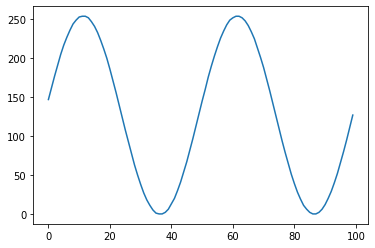

[147 162 177 191 205 217 227 236 244 249 253 254 254 252 247 241 233 223
 212 200 186 171 156 140 124 108  93  78  63  50  38  27  18  11   5   1
   0   0   2   6  13  20  30  41  54  67  82  97 113 129 145 160 176 190
 203 215 226 235 243 249 252 254 254 252 248 242 234 225 213 201 188 173
 158 142 126 110  94  79  65  51  39  28  19  11   6   2   0   0   2   6
  12  20  29  40  52  66  80  95 111 127]


<Figure size 432x288 with 0 Axes>

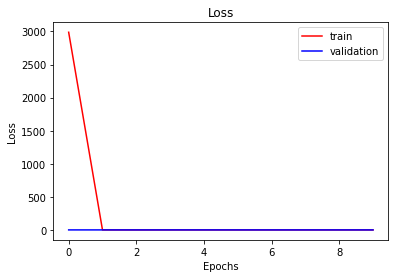

<Figure size 432x288 with 0 Axes>

In [13]:
#samplerate, wavarray = load_wavfile_as_array()

#model.reset_states()
#model = build_model()
#model.load_weights(tf.train.latest_checkpoint(checkpoint_dir))

plot.plot(wavarray[-100:])
plot.show()

print(wavarray[-100:])

loss=history.history['loss']
val_loss=history.history['val_loss']
epochs=range(len(loss))
plot.plot(epochs, loss, 'r')
plot.plot(epochs, val_loss, 'b')
plot.title('Loss')
plot.xlabel("Epochs")
plot.ylabel("Loss")
plot.legend(['train', 'validation'], loc='upper right')
plot.figure()


Generate new wavarray of output_length using initial_wavarray to seed the predictions.

In [14]:
def generate_wav(model, initial_wavarray, output_length):
    generated_wav = []
    progress = output_length / 10
    input_wavarray = initial_wavarray
    for i in range(output_length):
        if i % progress == 0:
            print(str(i) + " of " + str(output_length) + " completed at " + str(datetime.now()))
        # input_wavarray is shape (batch_size, sequence_length/window_size), e.g. shape (1, 300)
        # need it to be (batch_size, sequence_length/window_size, series dimensionality), e.g. shape (1, 300, 1)
        prediction_input = input_wavarray[:][np.newaxis]
        prediction_input = tf.expand_dims(prediction_input, axis=-1)
        prediction = model.predict(prediction_input)
        # Convert from np.int64 to avoid the following error:
        #tensorflow.python.framework.errors_impl.NotFoundError: Could not find valid device for node.
        #Node:{{node Conv2D}}
        #All kernels registered for op Conv2D :
        #  device='XLA_GPU'; T in [DT_FLOAT, DT_DOUBLE, DT_INT32, DT_BFLOAT16, DT_HALF]
        prediction = tf.cast(prediction, tf.int32)
        [predicted_value] = np.array(prediction)[:, 0]
        input_wavarray = np.append(input_wavarray[1:], [predicted_value])
        generated_wav.append(predicted_value)
    print("completed at " + str(datetime.now()))
    return generated_wav

# First prediction will be for the first sample after original file end
initial_input = wavarray[wavarray.size - window_size:]

generated_wav = np.array(generate_wav(model, initial_input, output_length), dtype=np.uint8)

0 of 110 completed at 2020-05-29 11:30:17.267046
11 of 110 completed at 2020-05-29 11:30:18.233153
22 of 110 completed at 2020-05-29 11:30:18.604540
33 of 110 completed at 2020-05-29 11:30:18.978761
44 of 110 completed at 2020-05-29 11:30:19.359812
55 of 110 completed at 2020-05-29 11:30:19.736097
66 of 110 completed at 2020-05-29 11:30:20.100115
77 of 110 completed at 2020-05-29 11:30:20.493462
88 of 110 completed at 2020-05-29 11:30:20.868741
99 of 110 completed at 2020-05-29 11:30:21.250121
completed at 2020-05-29 11:30:21.627212


Save the generated wav file.

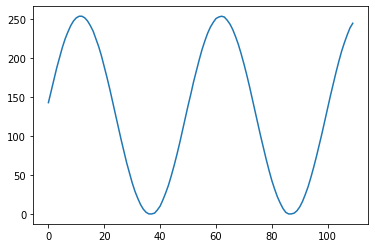

In [15]:
plot.plot(generated_wav)
plot.show()
#wavfile.write(output_file, samplerate, generated_wav)